# NeuroCluster:
<font size= 4> A Python toolbox for nonparametric cluster-based statistical testing of neurophysiological data with respect to continuous predictors 

First Authors: Alexandra Fink-Skular & Christina Maher  \
Updated: 11/10/2024 by AFS

In [1]:
# load required libraries
import os 
import numpy as np
import pandas as pd
from glob import glob
import NeuroCluster

In [2]:
%load_ext autoreload
%autoreload 2

# Step 1: Format input data (neural and behavioral)

The sample data for this notebook includes: 
- neural data: np.array (n_channels x n_trials x n_freqs x n_times)
- behavior data: pd.DataFrame (n_trials x n_variables)

These variables are extracted from an `mne.time_frequency.EpochsTFR` which is a spatiotemporal representation of neural data that includes power across trials, frequencies, and timepoints. Note, for this notebook we provide the neural and behavioral data in `np.array` *a priori*. These data can be found in the `sample_data_dir`.

In the following cell, let's load our template neural data into a dictionary and load the DataFrame of our behavioral predictors.

In [9]:
# Get absolute path to the installed data directory
sample_data_dir = os.path.join(os.path.dirname(NeuroCluster.__file__), 'data')
# see what's in the data directory
print('Contents of the sample data directory:')
print(os.listdir(sample_data_dir))

Contents of the sample data directory:
['channel_6.npy', 'channel_7.npy', 'channel_5.npy', 'channel_4.npy', 'channel_0.npy', 'channel_1.npy', 'channel_3.npy', 'channel_2.npy', 'channel_11.npy', 'channel_10.npy', 'channel_12.npy', 'channel_13.npy', 'channel_14.npy', 'channel_15.npy', 'sample_behavior.csv', 'channel_9.npy', 'channel_8.npy']


In [13]:
# extract sample data from package
sample_data_dir = os.path.join(os.path.dirname(NeuroCluster.__file__), 'data')
sample_ieeg_files = [f for f in os.listdir(sample_data_dir) if f.endswith('.npy')]
sample_ieeg_dict = {f.split(".")[0]: np.load(os.path.join(sample_data_dir, f)) for f in sample_ieeg_files}
ieeg_channels     = list(sample_ieeg_dict.keys())
csv_file = next(f for f in os.listdir(sample_data_dir) if f.endswith('.csv'))
sample_behav = pd.read_csv(os.path.join(sample_data_dir, csv_file))
freqs = np.logspace(*np.log10([2, 200]), num=30) # this information should be stored in the metadata of your neural data recording. 

Let's define the behavioral variables we plan to include as independent variables in our linear regression (`multi_reg_vars`) and the regressor of interest (`target_var`) we will permute to determine whether significant clusters encoding this behavioral variable exist in our time x frequency data. All continuous predictors should be normalized. 

In [14]:
# set main predictor of interest for permutations *target_var must be a continuous numeric variable*
target_var = 'error'

# define subset of predictor variables from sample_behav to include in regression (should include target_var)
multi_reg_vars = ['outcome','error']

# subset input dataframe to include only multi_reg_vars
predictor_data = sample_behav.copy()[multi_reg_vars]

# let's print the first few rows of the predictor data to make sure it looks right
predictor_data.head()


,outcome,error
0,good,2.264982
1,bad,0.650167
2,bad,0.160829
3,good,-0.573178
4,good,0.552299


# Step 2: Perform within-electrode cluster test.

First, let's create a variable called `tfr_data` which is a `np.array` (dimensions should correspond with number of trials x number of frequencies x number of timepoints)

In [15]:
# subset demo channel data from sample_ieeg_dict and store as tfr_data variable: np.array of (num epochs x num frequencies x num times)
demo_channel = 'channel_4'
tfr_data     = sample_ieeg_dict[demo_channel]

# check tfr_data dimensions - must be num trials, num frequencies, num timepoints
tfr_data.shape 
print(f'Number of trials for {demo_channel}: {tfr_data.shape[0]}')
print(f'Number of frequencies for {demo_channel}: {tfr_data.shape[1]}')
print(f'Number of timepoints for {demo_channel}: {tfr_data.shape[2]}')

Number of trials for channel_4: 150
Number of frequencies for channel_4: 30
Number of timepoints for channel_4: 1501


Next, let's create an instance of `TFR_Cluster_Test`. This will be used to run the cluster test. It requires the tfr_data, predictor_data, target_var, and demo_channel as inputs.

In [16]:
help(NeuroCluster.TFR_Cluster_Test)

Help on class TFR_Cluster_Test in module NeuroCluster.NeuroCluster:

class TFR_Cluster_Test(builtins.object)
 |  TFR_Cluster_Test(tfr_data, predictor_data, target_var, ch_name, alternative='two-sided', alpha=0.05, **kwargs)
 |  
 |  Single-electrode neurophysiology object class to identify time-frequency resolved neural activity correlates of complex behavioral variables using non-parametric 
 |  cluster-based permutation testing.   
 |  
 |  Attributes
 |  ----------
 |  tfr_data       : (np.array) Single electrode tfr data matrix. Array of floats (n_epochs,n_freqs,n_times). 
 |  tfr_dims       : (tuple) Frequency and time dimensions of tfr_data. Tuple of integers (n_freq,n_times). 
 |  ch_name        : (str) Unique electrode identification label. String of characters.
 |  predictor_data : (pd.DataFrame) Regressors from task behavior with continuous, discreet, or categorical data. DataFrame of (rows=n_epochs,columns=n_regressors). 
 |  target_var     : (str) Column label for primary r

In [17]:
cluster_test  = NeuroCluster.TFR_Cluster_Test(tfr_data,predictor_data,target_var,demo_channel)
cluster_test

To calculate t-critical for a two-sided hypothesis test, we compute a T-distribution with N-K-1 degrees of freedom (N=number of samples, K = number of predictors in regression model) and find the t-values where the area of the t-distribution = 0.025 and 0.975 (1-alpha/ntails,alpha=0.05,ntails=2). 

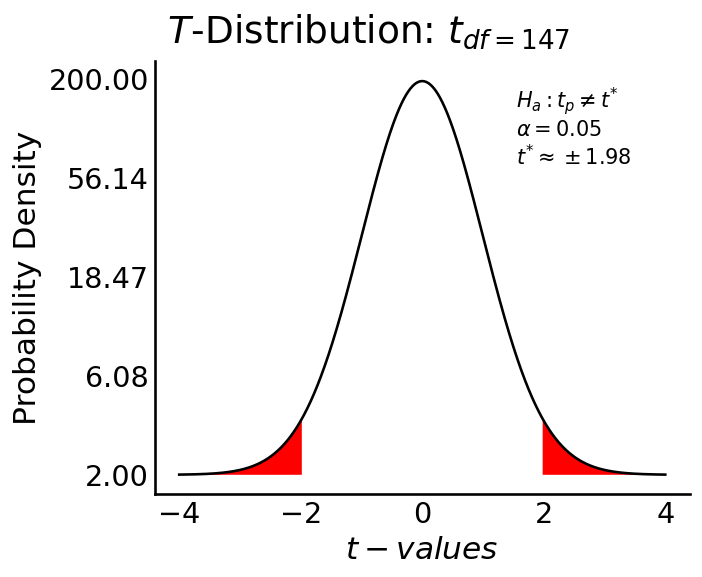

In [19]:
NeuroCluster.plotting_utils.plot_tcritical(cluster_test,freqs)

Now, we are reading to run our linear regression based on the dependent neural variable (`tfr_data`) and independent behavioral variables (`predictor_data`, `target_var`) we passed as inputs to our `TFR_Cluster_Test` object. This will return pixel-level **β coefficients** and corresponding **t-statistics** for our TFR data in one electrode.

In [20]:
betas, tstats = cluster_test.tfr_regression()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3336 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 44168 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    2.4s finished


Let's plot the **β coefficients** to give us an idea of the neural encoding pattern for our continuous predictor of interest.

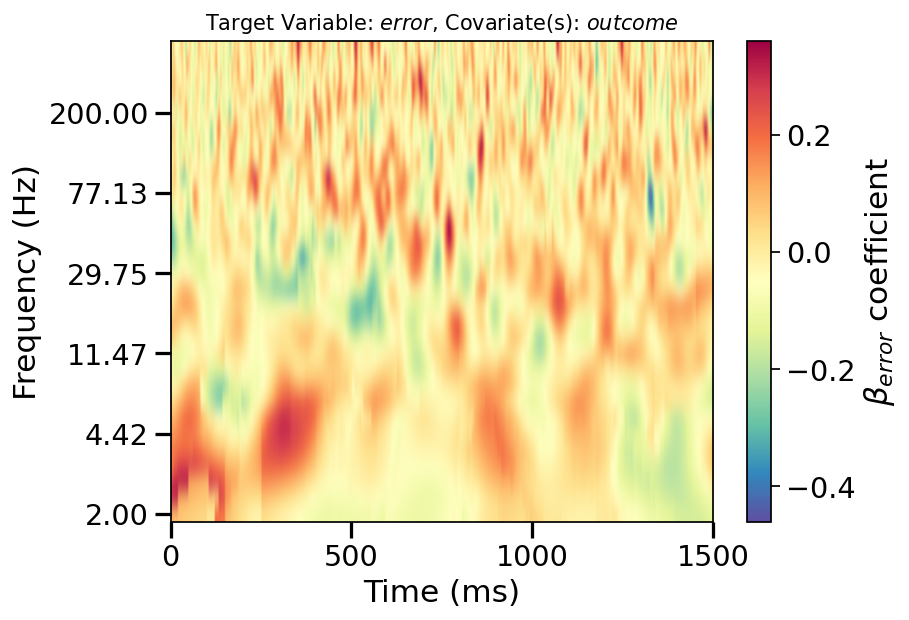

In [21]:
NeuroCluster.plot_beta_coef(betas,cluster_test,freqs)

We can also plot the **t-statistics** that correspond with the **β coefficient** for each time-frequency point.

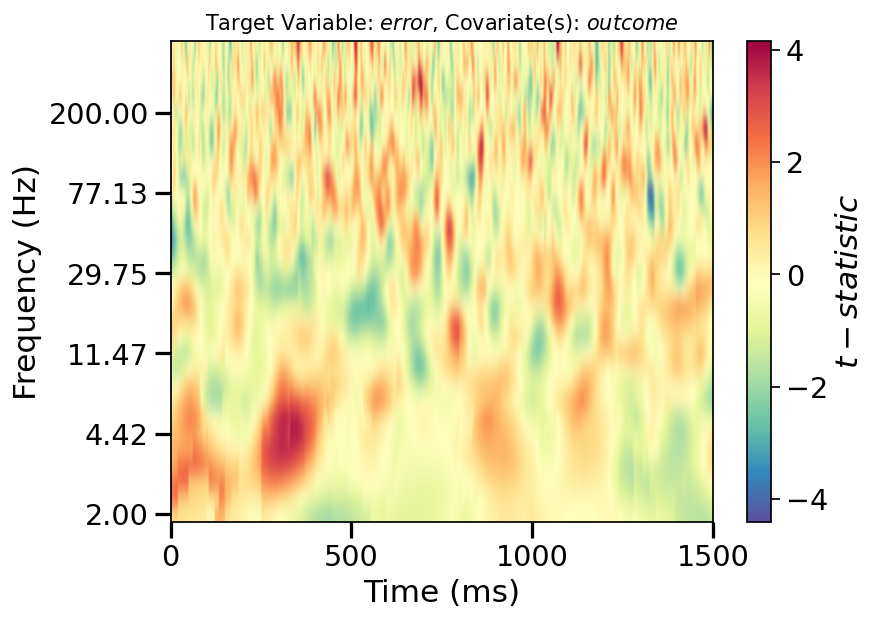

In [22]:
NeuroCluster.plot_tstats(tstats,cluster_test,freqs)

Let's highlight **clusters** (defined as consecutive time x frequency points) with significant t-statistics. We can do this separately for both positive and negative clusters. 

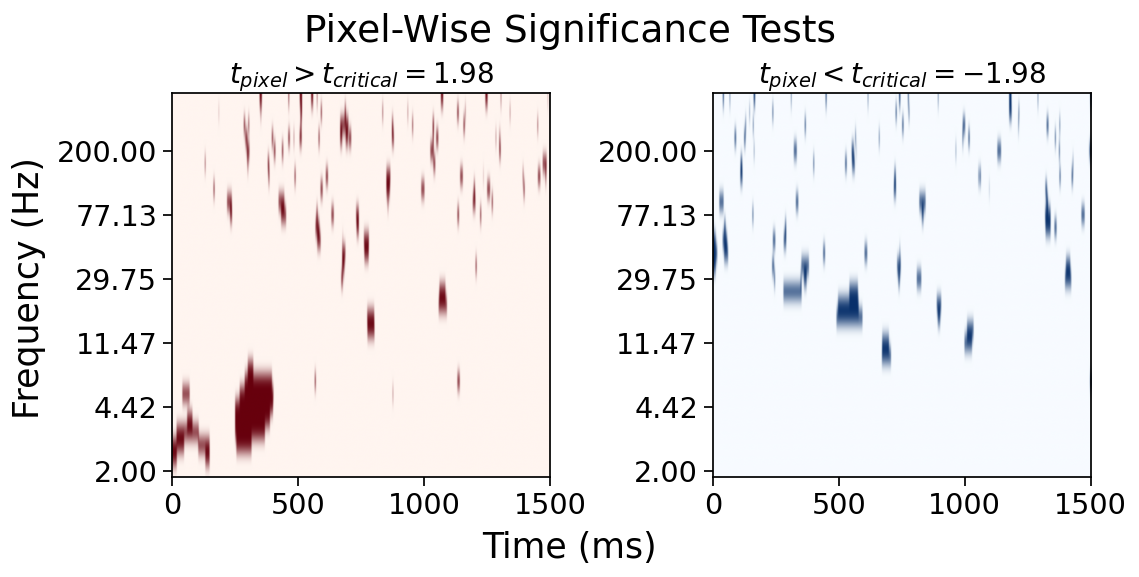

In [23]:
NeuroCluster.plot_clusters(tstats,cluster_test,freqs)

# Step 3: Calculate True Cluster Statistic(s) 

Now, we will identify the largest cluster (either/both positive and negative) and save the **cluster statistic** which will be our test statistic against our non-parametric null distribution. `max_tfr_cluster()` returns a dictionary containing the **cluster statistic**:`cluster_stat` and its associated **freq_idx**: `freq_idx` and **time_idx**:`time_idx`.

In [24]:
# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,max_cluster_output='all')
print(f'Max positive cluster dictionary: {max_cluster_data[0]}')
print(f'Max negative cluster dictionary: {max_cluster_data[1]}')

Max positive cluster dictionary: {'cluster_stat': np.float64(2108.9096700212563), 'freq_idx': (np.int64(2), np.int64(8)), 'time_idx': (np.int64(250), np.int64(401))}
Max negative cluster dictionary: {'cluster_stat': np.float64(-527.2224197852878), 'freq_idx': (np.int64(12), np.int64(14)), 'time_idx': (np.int64(489), np.int64(591))}


Let's plot our largest cluster and its associated **cluster statistic**

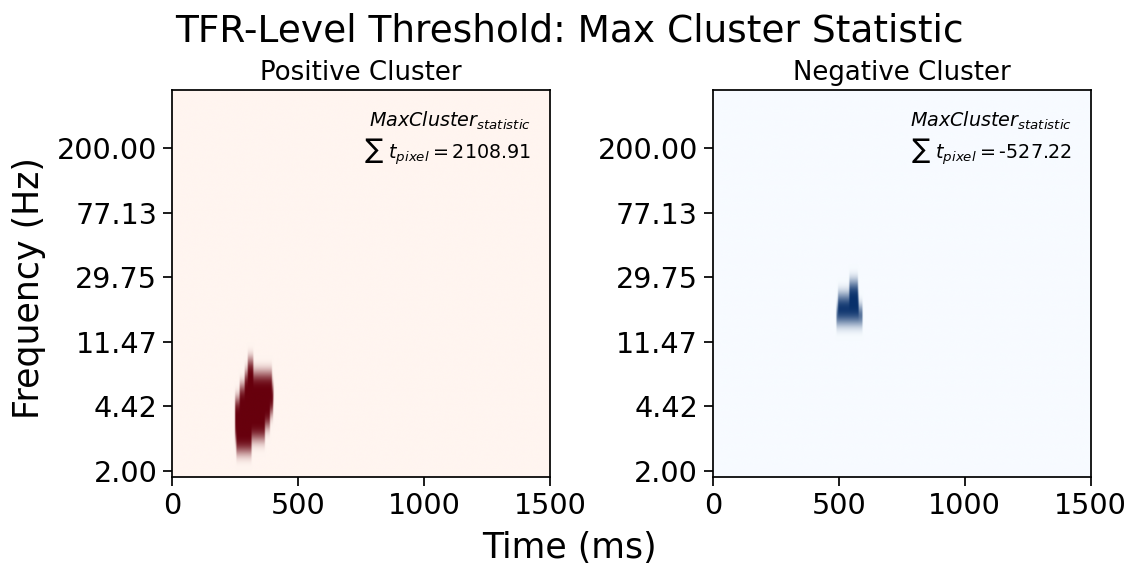

In [25]:
NeuroCluster.plot_max_clusters(cluster_test,tstats,freqs)
# TFR-Level Test Statistic: Largest Cluster

# Step 4: Compute cluster p-value(s) from null distribution of cluster statistics. 
To generate the null distribution, perform non-parametric cluster-based permutation testing by randomly permuting predictor of interest (target_var). 

At this point, we have computed the true cluster statistics from our neural (`tfr_data`) and behavioral data (`predictor_data`, `target_var`). Next, we will permute our input data and re-run the cluster identification procedure on each permuted dataset. This will allow us to generate a null distribution of cluster statistics, which we can use to evaluate the statistical significance of the cluster statistics observed in our true data.

`compute_null_cluster_stats()` takes `num_permutations` as an input, which specifies the desired number of permutations. The function will permute the regressor of interest according to this number. It returns a list of null cluster statistics, with the length of the list depending on the tails of the test. Here we generated 100 null cluster statistics, `num_permutations=100`, but we recommend running at least 200 permutations (500 to 1000 is best practice). 

In [26]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=100)

In [27]:
null_cluster_distribution

[[np.float64(463.7524480410173),
  np.float64(233.95688347530577),
  np.float64(573.4136150394911),
  np.float64(88.9281469282939),
  np.float64(577.0362517123481),
  np.float64(339.35630869622366),
  np.float64(319.06264597156303),
  np.float64(1225.6886244548402),
  np.float64(2541.3036740449143),
  np.float64(527.5058674818112),
  np.float64(698.4895090412399),
  np.float64(1878.3337211610078),
  np.float64(114.52886051647232),
  np.float64(232.44915942062676),
  np.float64(3013.106785122496),
  np.float64(192.77772874013718),
  np.float64(578.8611893330942),
  np.float64(308.0799614448133),
  np.float64(476.28435775300215),
  np.float64(906.1185818773381),
  np.float64(266.034504345109),
  np.float64(211.53974440986843),
  np.float64(192.20871364507633),
  np.float64(734.8080595461208),
  np.float64(416.1687744782108),
  np.float64(1705.3425959533865),
  np.float64(363.2137978886453),
  np.float64(194.15281760725483),
  np.float64(862.9608441545282),
  np.float64(420.9599415186492)

We will compute the ***p*-value** associated with our true cluster statistics based on the null distributions we create using `cluster_significance_test()`.

In [28]:
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) 
print(f'Positive cluster p-value: {cluster_pvalue[0]}')
print(f'Negative cluster p-value: {cluster_pvalue[1]}')

Positive cluster p-value: 0.07
Negative cluster p-value: 0.39


Let's create a plot showing the **null distribution(s)** we generated, with our true cluster statistic overlaid on top.

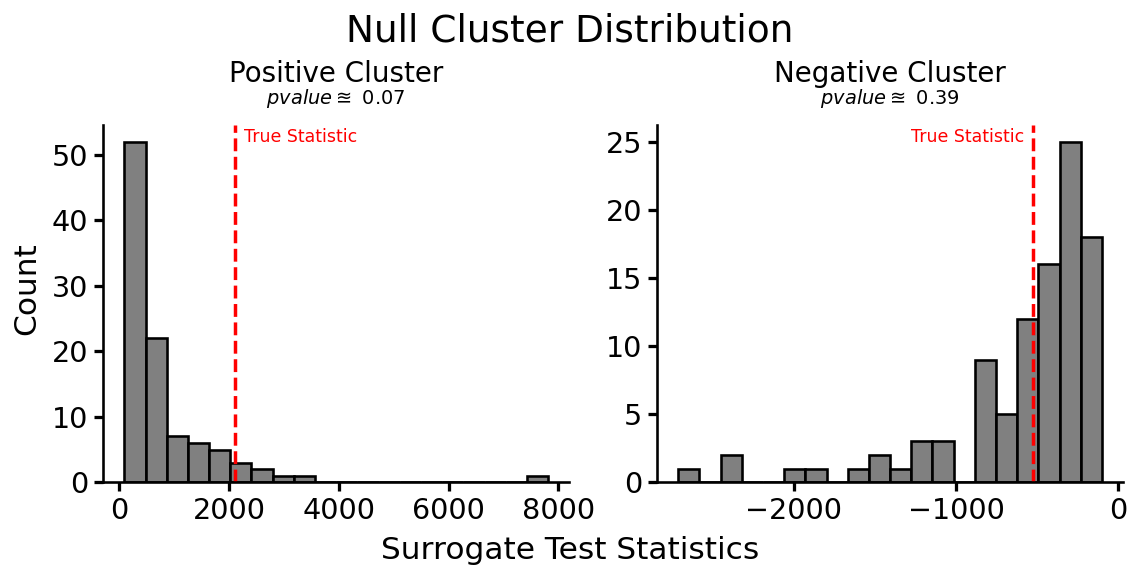

In [29]:
NeuroCluster.plot_null_distribution(null_cluster_distribution, max_cluster_data,cluster_pvalue,dpi=125)

In [ ]:
# Save all plots
tstat_threshold = cluster_test.threshold_tfr_tstat(tstats)
tcrit_plot,beta_plot,tstat_plot,cluster_plot,max_cluster_plot,null_distribution_plot = NeuroCluster.plot_neurocluster_results(betas,cluster_test,
                                                                                                                    max_cluster_data, null_cluster_distribution, tstats, tstat_threshold,cluster_pvalue,freqs)

# Create results directory to store the output
results_dir = os.path.join(os.path.dirname(NeuroCluster.__file__), 'results')

# Define the directory where you want to save the plots
output_directory = f'{results_dir}/{demo_channel}_{target_var}'

# Create the directory if it doesn't exist
NeuroCluster.create_directory(output_directory)

# Save plots to the output directory
NeuroCluster.save_plot_to_pdf(tcrit_plot, output_directory, f'{cluster_test.alternative}_tcrit_plot.pdf')
NeuroCluster.save_plot_to_pdf(beta_plot, output_directory, f'{cluster_test.alternative}_beta_plot.pdf')
NeuroCluster.save_plot_to_pdf(tstat_plot, output_directory, f'{cluster_test.alternative}_tstat_plot.pdf')
NeuroCluster.save_plot_to_pdf(cluster_plot, output_directory, f'{cluster_test.alternative}_cluster_plot.pdf')
NeuroCluster.save_plot_to_pdf(max_cluster_plot, output_directory, f'{cluster_test.alternative}_max_cluster_plot.pdf')
NeuroCluster.save_plot_to_pdf(null_distribution_plot, output_directory, f'{cluster_test.alternative}_null_distribution_plot.pdf')


# One-Sided Hypothesis Test Example
Rather than testing whether a tfr cluster significantly encodes our `target_var` in general, we can evaluate the directionality of `target_var` encoding in our cluster. Specifically, we can test whether neuronal activity in a cluster increases (or decreases) with increasing (or decreasing) values of the `target_var`.

In [32]:
cluster_test  = NeuroCluster.TFR_Cluster_Test(tfr_data,predictor_data,target_var,demo_channel,alternative='greater')
cluster_test

To calculate t-critical for a one-sided hypothesis test, we compute a T-distribution with N-K-1 degrees of freedom (N=number of samples, K = number of predictors in regression model) and find the t-value where the area of the t-distribution = 0.95 (1-alpha,alpha=0.05). 


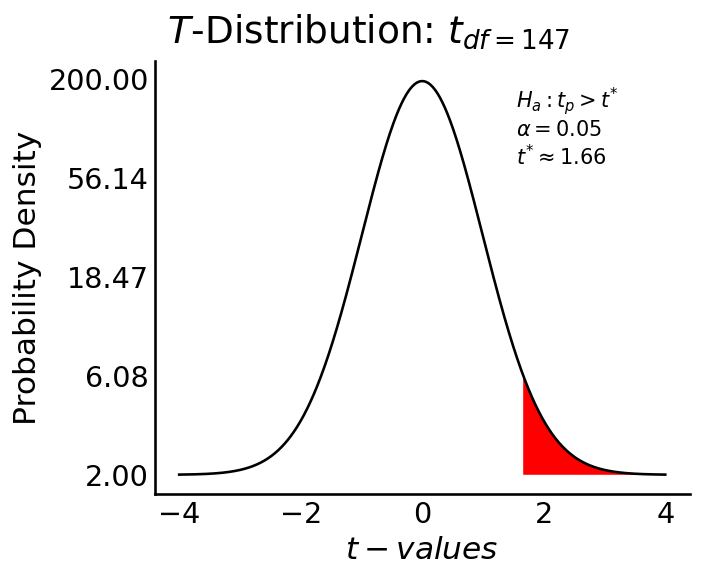

In [34]:
NeuroCluster.plotting_utils.plot_tcritical(cluster_test, freqs)

Now, we are reading to run our linear regression based on the dependent neural variable (`tfr_data`) and independent behavioral variables (`predictor_data`, `target_var`) we passed as inputs to our `TFR_Cluster_Test` object. This will return pixel-level **β coefficients** and corresponding **t-statistics** for our TFR data in one electrode.

In [35]:
betas, tstats = cluster_test.tfr_regression()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 43776 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    2.8s finished


Let's plot the **β coefficients** to give us an idea of the neural encoding pattern for our continuous predictor of interest.

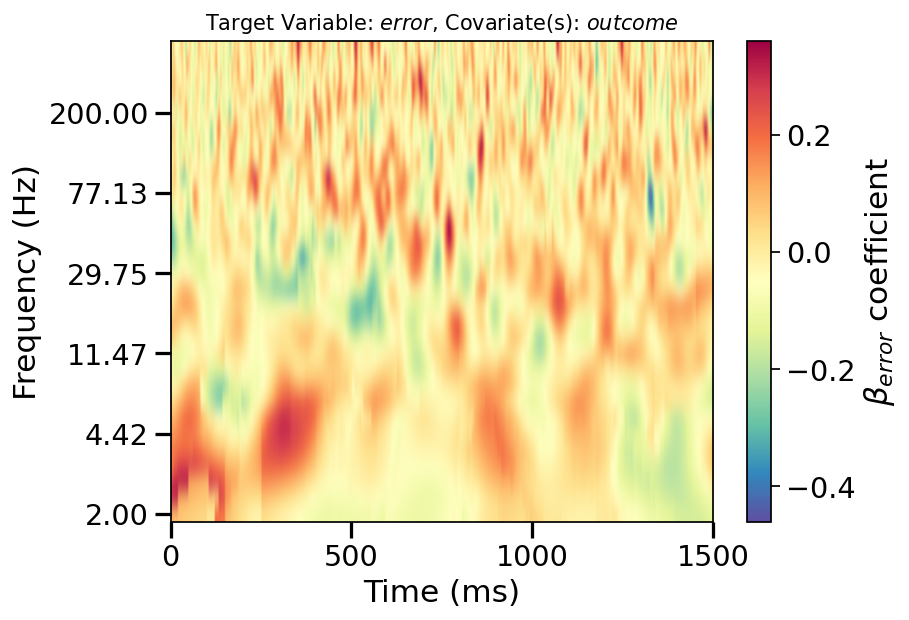

In [36]:
NeuroCluster.plot_beta_coef(betas,cluster_test,freqs)

We can also plot the **t-statistics** that correspond with the **β coefficient** for each time-frequency point.

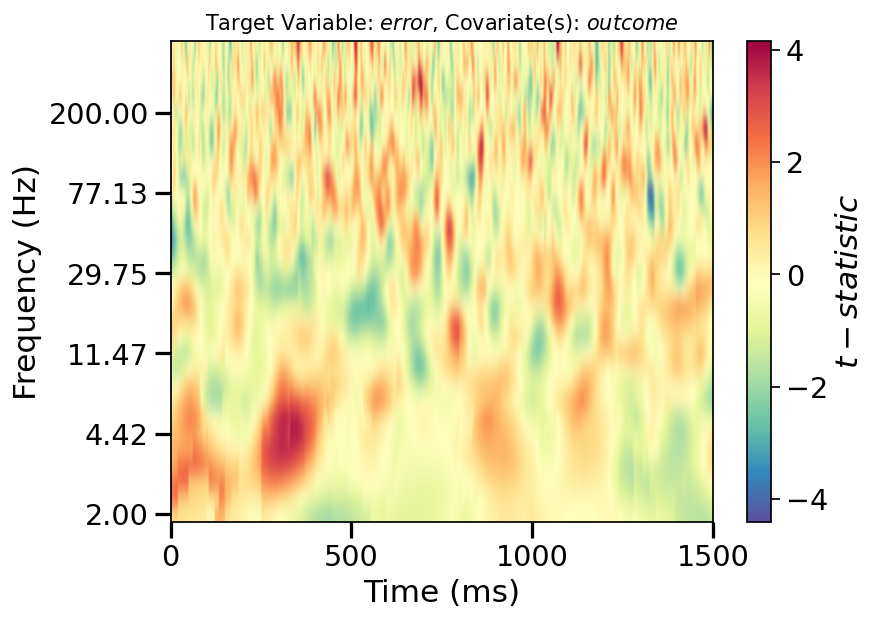

In [37]:
NeuroCluster.plot_tstats(tstats,cluster_test,freqs)

Let's highlight **clusters** (defined as consecutive time x frequency points) with significant t-statistics.

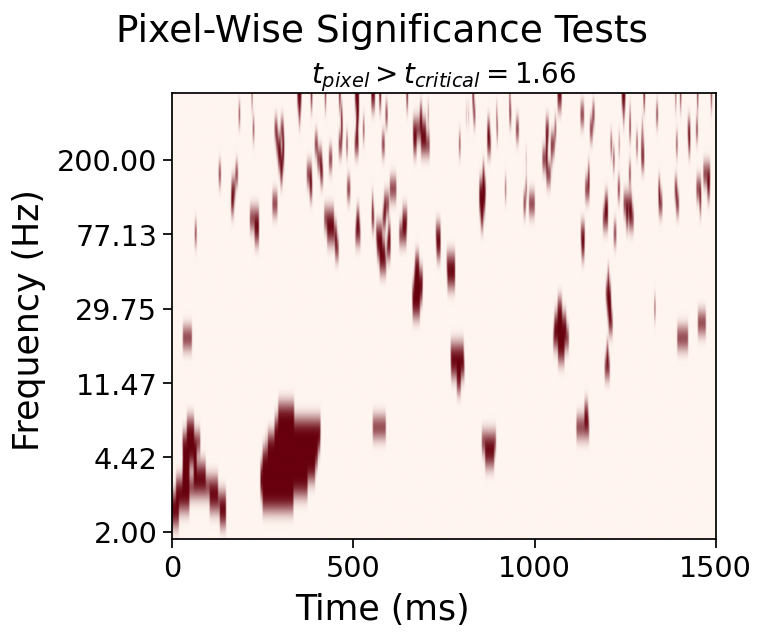

In [38]:
NeuroCluster.plot_clusters(tstats,cluster_test,freqs,figsize=(6,5))

# Step 3: Calculate True Cluster Statistic(s) 

Now, we will identify the largest cluster (either/both positive and negative) and save the **cluster statistic** which will be our test statistic against our non-parametric null distribution. `max_tfr_cluster()` returns a dictionary containing the **cluster statistic**:`cluster_stat` and its associated **freq_idx**: `freq_idx` and **time_idx**:`time_idx`.

In [39]:
# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,max_cluster_output='all')
print(f'Max positive cluster dictionary: {max_cluster_data[0]}')

Max positive cluster dictionary: {'cluster_stat': np.float64(2300.5671671842842), 'freq_idx': (np.int64(2), np.int64(8)), 'time_idx': (np.int64(244), np.int64(409))}


Let's plot our **positive** largest cluster and its associated **cluster statistic**

UnboundLocalError: local variable 'axs' referenced before assignment

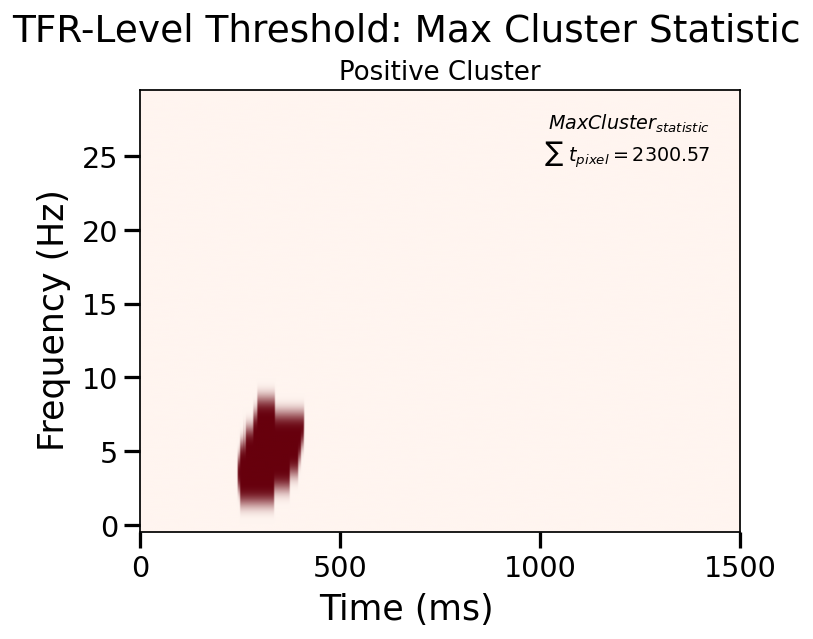

In [41]:
NeuroCluster.plot_max_clusters(cluster_test,tstats,freqs,figsize=(6,5))

# Step 4: Compute cluster p-value(s) from null distribution of cluster statistics. 
To generate the null distribution, perform non-parametric cluster-based permutation testing by randomly permuting predictor of interest (target_var). 

At this point, we have computed the true cluster statistics from our neural (`tfr_data`) and behavioral data (`predictor_data`, `target_var`). Next, we will permute our input data and re-run the cluster identification procedure on each permuted dataset. This will allow us to generate a null distribution of cluster statistics, which we can use to evaluate the statistical significance of the cluster statistics observed in our true data.

`compute_null_cluster_stats()` takes `num_permutations` as an input, which specifies the desired number of permutations. The function will permute the regressor of interest according to this number. It returns a list of null cluster statistics, with the length of the list depending on the tails of the test. Here we generated 100 null cluster statistics, `num_permutations=100`, but we recommend running at least 200 permutations (500 to 1000 is best practice). 

In [ ]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=100)

We will compute the ***p*-value** associated with our true cluster statistics based on the null distributions we create using `cluster_significance_test()`.

In [ ]:
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) 
print(f'Positive cluster p-value: {cluster_pvalue[0]}')

Let's create a plot showing the **null distribution(s)** we generated, with our true cluster statistic overlaid on top.

In [ ]:
NeuroCluster.plot_null_distribution(null_cluster_distribution, max_cluster_data,cluster_pvalue,figsize=(6,5),dpi=125)

# Trying to replicate findings using MNE's built-in t-test functionality

When using a t-test to analyze a continuous variable, there is a risk of encountering false negatives (i.e., failing to detect a true effect), as demonstrated in this example. This issue arises because the t-test may not fully capture the complexity or structure of the data, leading to inaccurate conclusions. This underscores the advantages of NeuroCluster's approach, which provides a more robust method for capturing complex data structures and reducing the risk of false negatives.



In [ ]:
# Let's see if we get the same result as Neurocluster (a significant positive cluster meaning as error increases, encoding increases), using mne's built-in two sample t-test cluster function
import mne

# Let's take a median split for the error variable and assign it to high and low error variables (we need to discretize the error variable for the mne function)
error = sample_behav['error']
median_error = np.median(error)
low_error = tfr_data[error < median_error, :, :]    
high_error = tfr_data[error >= median_error, :, :]

# Let's run the mne two sample t-test cluster function
t_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test([low_error, high_error], n_permutations=1000, tail=0)



In [ ]:
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_pv[i_c] <= 0.05:
        print(f"Cluster {i_c} p-value: {cluster_pv[i_c]}")
    else:
        print("No significant clusters found")

# Let's run the entire pipeline at once and save plots. 

In [ ]:
### NeuroCluster single electrode workflow: 

# Step 1: Create TFR_Cluster_Test Object
cluster_test  = NeuroCluster.TFR_Cluster_Test(tfr_data,predictor_data,target_var,demo_channel,alternative='two-sided')

# Step 2: Run TFR regression to extract beta coefficients for predictor of interest (permute_var) & tstats for each pixel in TFR. Determine which t-statistics are significant based on the critical t-value and save a thresholded t-statistic matrix.
betas, tstats = cluster_test.tfr_regression()
tstat_threshold = cluster_test.threshold_tfr_tstat(tstats)

# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,max_cluster_output='all')

# Step 4: Create null distribution of maximum cluster statistics from permuted data
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=100)

# Step 5: Use null cluster statistic distribution from permutations to compute non-parametric p value 
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) 

# Let's plot all the steps together and save the figures to a dictory that corresponds to the channel and predictor of interest. 
tcrit_plot,beta_plot,tstat_plot,cluster_plot,max_cluster_plot,null_distribution_plot = NeuroCluster.plot_neurocluster_results(betas,cluster_test, max_cluster_data, null_cluster_distribution, tstats, tstat_threshold,cluster_pvalue,freqs)

# Define the directory where you want to save the plots
output_directory = f'{results_dir}/{demo_channel}_{target_var}'

# Create the directory if it doesn't exist
NeuroCluster.create_directory(output_directory)

# Save plots to the output directory
NeuroCluster.save_plot_to_pdf(beta_plot, output_directory, 'beta_plot.pdf')
NeuroCluster.save_plot_to_pdf(tstat_plot, output_directory, 'tstat_plot.pdf')
NeuroCluster.save_plot_to_pdf(cluster_plot, output_directory, 'cluster_plot.pdf')
NeuroCluster.save_plot_to_pdf(max_cluster_plot, output_directory, 'max_cluster_plot.pdf')
NeuroCluster.save_plot_to_pdf(null_distribution_plot, output_directory, 'null_distribution_plot.pdf')